# Insurance Policy Generation Chatbot

In the insurance industry, the process of generating new policies or documents can be time-consuming and tedious. To optimize this process, we can use AI-powered chatbots that act as assistants and advisors to insurance companies during the policy creation process. These chatbots can help streamline the process and provide reliable and accurate information to customers.

In [14]:
from haystack.telemetry import tutorial_running
import logging
from haystack.nodes import TextConverter, PDFToTextConverter, DocxToTextConverter, PreProcessor
from haystack.utils import convert_files_to_docs
from haystack.nodes import PreProcessor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import squarify
import matplotlib.pyplot as plt
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
#import spacy
from collections import Counter




#tutorial_running(8)

## Logging

We configure how logging messages should be displayed and which log level should be used before importing Haystack.
Example log message:
INFO - haystack.utils.preprocessing -  Converting data/tutorial1/218_Olenna_Tyrell.txt
Default log level in basicConfig is WARNING so the explicit parameter is not necessary but can be changed easily:

In [15]:

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.INFO)

## Converters

Haystack's converter classes are designed to help you turn files on your computer into the documents
that can be processed by the Haystack pipeline.
There are file converters for txt, pdf, docx files as well as a converter that is powered by Apache Tika.
The parameter `valid_languages` does not convert files to the target language, but checks if the conversion worked as expected. Here are some examples of how you would use file converters:

In [ ]:

#converter = TextConverter(remove_numeric_tables=True, valid_languages=["en"])
#doc_txt = converter.convert(file_path="data/tutorial8/classics.txt", meta=None)[0]

import os

directory = 'docs/dataset/'

for filename in os.listdir(directory):
    print(filename)
    
    file_path = os.path.join(directory, filename)
    if os.path.isfile(file_path):
        with open(file_path, 'r') as file:
            
            converter = PDFToTextConverter(remove_numeric_tables=True, valid_languages=["es"])
            doc_pdf = converter.convert(file_path="C:/Users/.../insurance_dataset/POL120190177", meta=None)[0]

           # content = file.read()
        print(f"Contenido de {filename}")

#converter = PDFToTextConverter(remove_numeric_tables=True, valid_languages=["es"])
#doc_pdf = converter.convert(file_path="C:/Users/.../insurance_dataset/POL120190177", meta=None)[0]

#converter = DocxToTextConverter(remove_numeric_tables=False, valid_languages=["en"])
#doc_docx = converter.convert(file_path="data/tutorial8/heavy_metal.docx", meta=None)[0]

POL320130223.pdf
Contenido de POL320130223.pdf
POL320150503.pdf
Contenido de POL320150503.pdf
POL320180100.pdf
Contenido de POL320180100.pdf
POL320190074.pdf
Contenido de POL320190074.pdf
POL320200071.pdf
Contenido de POL320200071.pdf
POL320200214.pdf
Contenido de POL320200214.pdf
POL320210063.pdf
Contenido de POL320210063.pdf
POL320210210.pdf
Contenido de POL320210210.pdf


Haystack also has a convenience function that will automatically apply the right converter to each file in a directory:

In [26]:
all_docs = convert_files_to_docs(dir_path="docs/dataset/")

FileNotFoundError: pdftotext is not installed. It is part of xpdf or poppler-utils software suite.

                   Installation on Linux:
                   wget --no-check-certificate https://dl.xpdfreader.com/xpdf-tools-linux-4.04.tar.gz &&
                   tar -xvf xpdf-tools-linux-4.04.tar.gz && sudo cp xpdf-tools-linux-4.04/bin64/pdftotext /usr/local/bin

                   Installation on MacOS:
                   brew install xpdf

                   You can find more details here: https://www.xpdfreader.com
                

In [23]:
len(all_docs)

0

## PreProcessor

The PreProcessor class is designed to help you clean text and split text into sensible units.
File splitting can have a very significant impact on the system's performance and is absolutely mandatory for Dense Passage Retrieval models.
In general, we recommend you split the text from your files into small documents of around 100 words for dense retrieval methods
and no more than 10,000 words for sparse methods.
Have a look at the [Preprocessing](https://docs.haystack.deepset.ai/docs/preprocessor)
and [Optimization](https://docs.haystack.deepset.ai/docs/optimization) pages on our website for more details.

In [ ]:
# This is a default usage of the PreProcessor.
# Here, it performs cleaning of consecutive whitespaces
# and splits a single large document into smaller documents.
# Each document is up to 1000 words long and document breaks cannot fall in the middle of sentences
# Note how the single document passed into the document gets split into 5 smaller documents

preprocessor = PreProcessor(
    clean_empty_lines=True,
    clean_whitespace=True,
    clean_header_footer=False,
    split_by="word",
    split_length=100,
    split_respect_sentence_boundary=True,
)

docs_default = []
processed_docs = []

for i, doc in enumerate(all_docs):
    processed_parts = preprocessor.process(doc)  
    docs_default.extend(processed_parts) 
    processed_docs.append(processed_parts) 
    
print(f"n_docs_input: {len(all_docs)}") 
print(f"n_docs_output: {len(docs_default)}") 
    
#docs_default = preprocessor.process(all_docs[0])
#print(f"n_docs_input: 1\nn_docs_output: {len(docs_default)}")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\joeya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
C:\Users\joeya\AppData\Local\Temp\ipykernel_58516\1551490772.py:23: DeprecationWarning: Using a single Document as argument to the 'documents' parameter is deprecated. Use a list of (a single) Document instead.
  processed_parts = preprocessor.process(doc)
WARNING - haystack.nodes.preprocessor.preprocessor -  We found one or more sentences whose split count is higher than the split length.


n_docs_input: 9
n_docs_output: 1032


In [66]:
print(len(docs_default))
print(len(processed_docs))

1032
9


## Cleaning

- `clean_empty_lines` will normalize 3 or more consecutive empty lines to be just a two empty lines
- `clean_whitespace` will remove any whitespace at the beginning or end of each line in the text
- `clean_header_footer` will remove any long header or footer texts that are repeated on each page

In [ ]:

# Extract text from documents
texts = [doc.content for doc in docs_default]

# Create DataFrame
df = pd.DataFrame({"text": texts})

# Add columns with number of words and characters
df["num_words"] = df["text"].apply(lambda x: len(x.split()))
df["num_chars"] = df["text"].apply(lambda x: len(x))

# Show summary statistics
print(df[["num_words", "num_chars"]].describe()) 
print(f"Total words: {df['num_words'].sum()}")  
print(f"Total chars: {df['num_chars'].sum()}") 



         num_words    num_chars
count  1032.000000  1032.000000
mean     79.892442   523.537791
std      22.795661   150.011440
min      12.000000    80.000000
25%      69.750000   443.500000
50%      83.000000   541.000000
75%      93.000000   612.000000
max     320.000000  1960.000000
Total words: 82449
Total chars: 540291


In [73]:
df.head()
#len(df)

,text,num_words,num_chars
0,PÓLIZA DE ACCIDENTES PERSONALES / REEMBOLSO GA...,74,511
1,ARTÍCULO 2º: COBERTURA Y MATERIA ASEGURADA\nLa...,51,364
2,"Lo anterior, cuando al asegurado le ocurra un ...",86,533
3,La compañía reembolsará los gastos referidos p...,149,948
4,Los reembolsos al Asegurado o pago al Prestado...,132,841


## Text Distribution

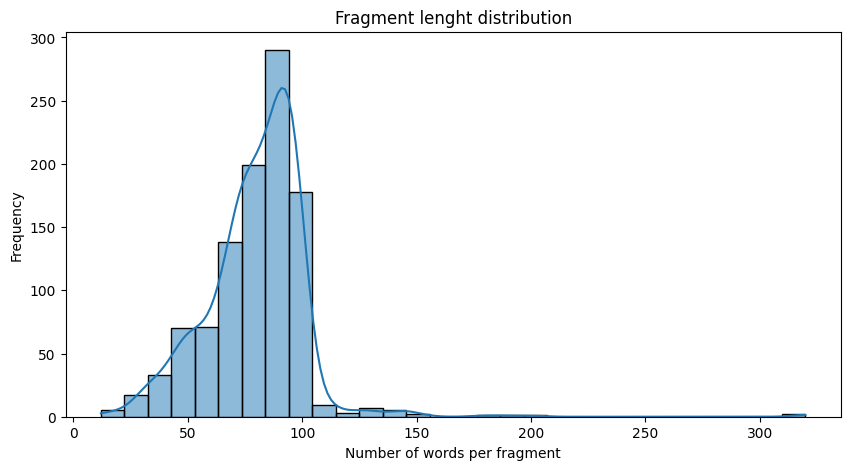

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df["num_words"], bins=30, kde=True)
plt.xlabel("Number of words per fragment")
plt.ylabel("Frequency")
plt.title("Fragment lenght distribution")
plt.show()


In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joeya\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [ ]:
def remove_stopwords(text, stop_words):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

In [ ]:

text = " ".join(doc.content for doc in docs_default)

filtered_text = remove_stopwords(text, stop_words)

print(filtered_text)

PÓLIZA ACCIDENTES PERSONALES / REEMBOLSO GASTOS MÉDICOS Incorporada Depósito Pólizas bajo código POL120190177 ARTÍCULO 1°: REGLAS APLICABLES CONTRATO aplicarán presente contrato seguro disposiciones contenidas artículos siguientes normas legales carácter imperativo establecidas título VIII, Libro II, Código Comercio. embargo, entenderán válidas estipulaciones contractuales beneficiosas asegurado beneficiario. ARTÍCULO 2º: COBERTURA MATERIA ASEGURADA Compañía Aseguradora reembolsará asegurado pagará directamente prestador salud Gastos Médicos Razonables Acostumbrados Efectivamente Incurridos, vez otorgado pagado cobertura sistema salud previsional, seguros complementarios u beneficios contratados asegurado. anterior, asegurado ocurra accidente vigencia póliza demande internación hospitalaria gasto realice prestadores salud asegurador determine, período duración Reembolso establezca Condiciones Particulares Póliza, inicia fecha ocurrencia Accidente originados éste. definiciones conceptos

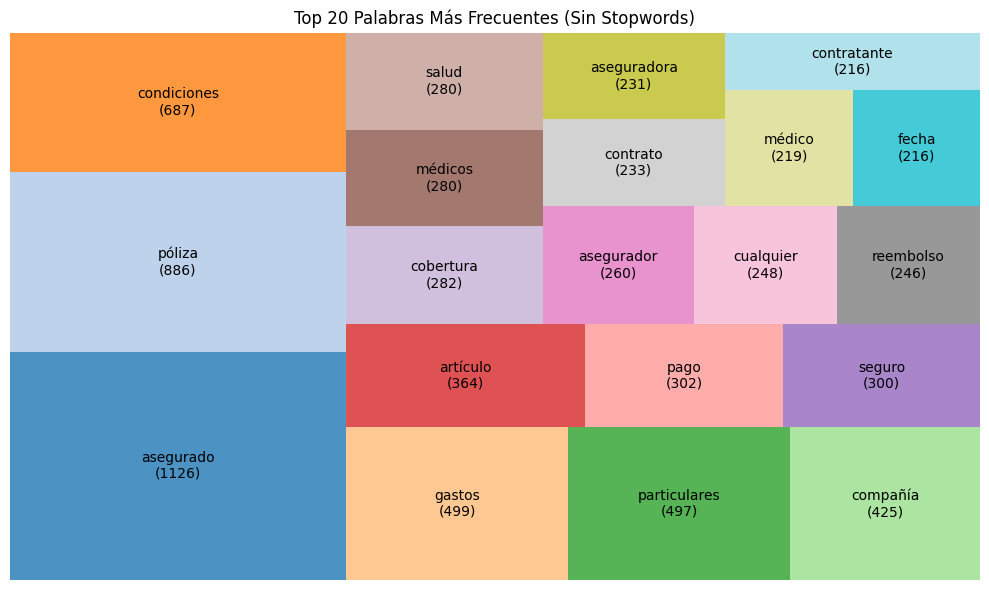

In [ ]:

# Text cleaning
filtered_text = re.sub(r'[^\w\s]', '', filtered_text.lower())

word_counts = Counter(filtered_text.split())

# select more common words 
top_n = 20
top_words = word_counts.most_common(top_n)

# Data preparation
words, counts = zip(*top_words)
sizes = list(counts)
labels = [f"{word}\n({count})" for word, count in top_words]


plt.figure(figsize=(10, 6))
squarify.plot(sizes=sizes, label=labels, alpha=0.8, color=plt.cm.tab20.colors)
plt.title(f'Top {top_n} Palabras Más Frecuentes (Sin Stopwords)')
plt.axis('off')
plt.tight_layout()
plt.show()

## Analysis of possible categories or topics

In [ ]:

vectorizer = TfidfVectorizer(stop_words="english", max_features=100)
X = vectorizer.fit_transform([doc.content for doc in docs_default])

df_tfidf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
df_tfidf.head()


,accidente,acuerdo,al,aquellos,artículo,asegurado,asegurador,aseguradora,asegurados,bajo,...,su,sus,tales,titular,todo,tratamiento,tratamientos,términos,una,vigencia
0,0.000000,0.000000,0.366481,0.0,0.164035,0.099347,0.00000,0.000000,0.0,0.223522,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.240275,0.0,0.161319,0.195403,0.00000,0.189138,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.148264,0.000000
2,0.346575,0.000000,0.084431,0.0,0.113373,0.068664,0.14002,0.000000,0.0,0.000000,...,0.104198,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.151695
3,0.201500,0.000000,0.049089,0.0,0.065916,0.079843,0.00000,0.000000,0.0,0.000000,...,0.060581,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.060581,0.176392
4,0.000000,0.137948,0.208484,0.0,0.000000,0.282581,0.00000,0.109408,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.130321,0.0,0.0,0.140222,0.000000,0.000000


## Analysis of entities and legal terms

In [ ]:

# to download the model run python -m spacy download es_core_news_sm in terminal
nlp = spacy.load("es_core_news_sm") 
doc = nlp(all_docs[0].content)

for ent in doc.ents:
    print(f"{ent.text} -> {ent.label_}")




PÓLIZA -> ORG
ACCIDENTES -> ORG
PERSONALES -> ORG
REEMBOLSO -> ORG
GASTOS MÉDICOS
Incorporada -> MISC
Depósito de Pólizas -> MISC
POL120190177
ARTÍCULO 1 -> MISC
REGLAS APLICABLES AL -> MISC
Libro II -> MISC
Código de Comercio -> LOC
ARTÍCULO -> ORG
COBERTURA -> MISC
MATERIA ASEGURADA
La Compañía Aseguradora -> MISC
Gastos Médicos Razonables -> MISC
Acostumbrados -> LOC
Efectivamente Incurridos -> LOC
Lo anterior -> MISC
determine -> PER
Reembolso -> PER
Condiciones Particulares de la Póliza -> ORG
Accidente -> MISC
Las definiciones de estos conceptos -> MISC
Condiciones Generales -> ORG
Accidente que los origina -> MISC
Asegurado -> ORG
Póliza -> LOC
Período de Duración de Reembolso -> PER
Deducible -> MISC
Condiciones Particulares de la Póliza -> ORG
Póliza -> LOC
Monto Máximo -> PER
Gastos Reembolsables -> LOC
Condiciones Particulares -> ORG
Póliza -> LOC
Artículo 5° -> MISC
Condiciones Generales -> ORG
prestador(es -> MISC
Condiciones Particulares -> ORG
Póliza -> LOC
Asegurado -> 

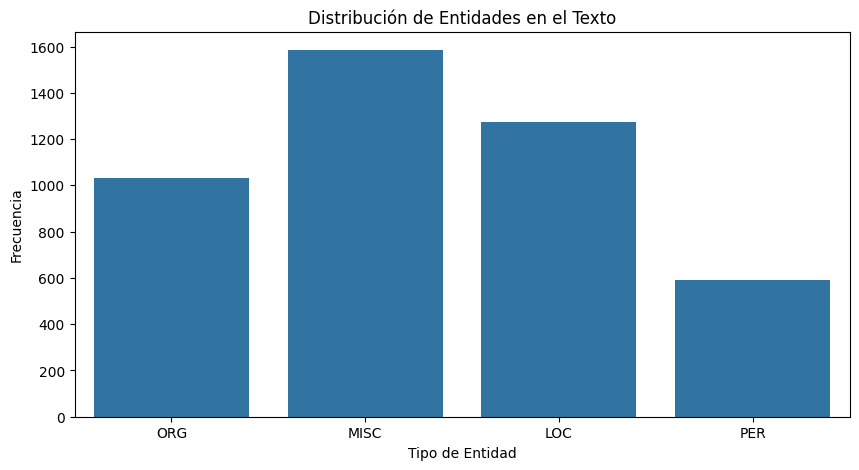

In [ ]:

# Load spaCy emodel in spanish
nlp = spacy.load("es_core_news_sm")


doc = nlp(text)


entities = [ent.label_ for ent in doc.ents]
entity_counts = Counter(entities)


plt.figure(figsize=(10, 5))
sns.barplot(x=list(entity_counts.keys()), y=list(entity_counts.values()))
plt.xlabel("Entity type")
plt.ylabel("Frequency")
plt.title("Entity type distribution")
plt.show()



In [ ]:

nltk.download('punkt')
tokens = nltk.word_tokenize(docs_default[0].content)

bigrams = list(ngrams(tokens, 2))
trigrams = list(ngrams(tokens, 3))

bigram_freq = Counter(bigrams)
trigram_freq = Counter(trigrams)

print("Bigramas más comunes:", bigram_freq.most_common(10))
print("Trigramas más comunes:", trigram_freq.most_common(10))




Bigramas más comunes: [((',', 'del'), 2), (('PÓLIZA', 'DE'), 1), (('DE', 'ACCIDENTES'), 1), (('ACCIDENTES', 'PERSONALES'), 1), (('PERSONALES', '/'), 1), (('/', 'REEMBOLSO'), 1), (('REEMBOLSO', 'GASTOS'), 1), (('GASTOS', 'MÉDICOS'), 1), (('MÉDICOS', 'Incorporada'), 1), (('Incorporada', 'al'), 1)]
Trigramas más comunes: [(('PÓLIZA', 'DE', 'ACCIDENTES'), 1), (('DE', 'ACCIDENTES', 'PERSONALES'), 1), (('ACCIDENTES', 'PERSONALES', '/'), 1), (('PERSONALES', '/', 'REEMBOLSO'), 1), (('/', 'REEMBOLSO', 'GASTOS'), 1), (('REEMBOLSO', 'GASTOS', 'MÉDICOS'), 1), (('GASTOS', 'MÉDICOS', 'Incorporada'), 1), (('MÉDICOS', 'Incorporada', 'al'), 1), (('Incorporada', 'al', 'Depósito'), 1), (('al', 'Depósito', 'de'), 1)]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joeya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
